In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '48_f1'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y_ce(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.875)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

In [17]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y_ce(y_img[:,:,0])

In [18]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

## U-net (ish)

In [21]:
from torchvision.models import vgg11_bn

In [22]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [23]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [24]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [25]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [26]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [27]:
class Unet34Mod(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5 = UnetBlock(64,32,32)
        self.up6 = nn.ConvTranspose2d(32, out, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(out,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [28]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
        return lgs + [children(model)[1:]]

In [29]:
def carce_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,:,:]==1, beta=2)

In [30]:
def rdce_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,:,:]==2, beta=0.5)
    return f

In [31]:
def carsig_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(p2[:,0,:,:], targs[:,0,:,:], beta=2, threshold=0.5)

In [32]:
def rdsig_f(pred, targs):
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(p2[:,1,:,:], targs[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [33]:
def car_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,1,:,:], beta=2)

In [34]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,2,:,:], beta=0.5)
    return f

In [35]:
def new_acc_sig(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()

In [36]:
def new_acc_ce(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()

In [37]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
    return (idx == t_idx).float().mean()

In [38]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, softmax=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [39]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [40]:
def lyft_score(pred, target, weight):
    num,c,h,w = pred.shape
    pred = pred.view(num, c, -1)  # Flatten
    target = target.view(num, c, -1)  # Flatten
    intersection = (pred * target)
    int_sum = intersection.sum(dim=-1)
    pred_sum = pred.sum(dim=-1)
    targ_sum = target.sum(dim=-1)
    
    eps = 1e-9
    precision = int_sum / (pred_sum + eps)
    recall = int_sum / (targ_sum + eps)
    beta = V(weight ** 2)
    
    fnum = (1.+beta) * precision * recall
    fden = beta * precision + recall + eps
    
    fscore = fnum / fden
    
#     fb = (precision*recall)/precision*beta + recall + eps
    
    avg_w = torch.cuda.FloatTensor([0,.5,.5])
    favg = V(avg_w) * fscore
#     pdb.set_trace()
    return favg.sum(dim=-1)

class FLoss(nn.Module):
    def __init__(self, weight=torch.cuda.FloatTensor([1,2,0.5]), softmax=True):
        super().__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        score = lyft_score(probs, targets, self.weight)
        score = 1 - score.sum() / num
        return score

In [41]:
def get_learner(md, m_fn=Unet34Mod, weights=[1,200,2], half=False, softmax=True, dice=False):
    out_sz = 3 if softmax else 2
    m = to_gpu(m_fn(out_sz))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor(weights)
    if half:
        class_weights = class_weights.half()
        learn.half()
        
#     if dice: learn.crit=SoftDiceLoss(weight=class_weights, softmax=softmax)
#     else: learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit = FLoss(softmax=softmax)
    
    if softmax: learn.metrics = [new_acc_ce, rdce_f, carce_f_p_r]
    else: learn.metrics = [new_acc_sig, rdsig_f, carsig_f_p_r]
    # learn.metrics=[new_acc, rd_f, car_f_p_r]
    
    return learn

### Models

In [50]:
ext = '-300'
sz=192
bs=64
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [52]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,10,2], softmax=True)
learn.load(f'600urn-46_wide-384-nocrop-w8-pt3')

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.247546   0.229154   0.950249   0.96414    0.768188   0.512816   0.878824  



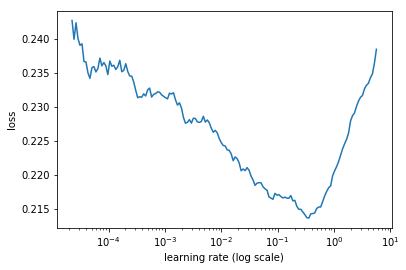

In [53]:
learn.lr_find()
learn.sched.plot()

In [55]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [57]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [58]:
learn.fit(lr, 1, wds=wd, cycle_len=30,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.202848   0.184353   0.964049   0.977637   0.823035   0.721886   0.855969  
    1      0.206022   0.196577   0.979604   0.982654   0.722343   0.802145   0.70901   
    2      0.202916   0.192921   0.974153   0.984009   0.724195   0.777986   0.715998  
    3      0.203626   0.207406   0.966861   0.969568   0.748537   0.640312   0.788723  
    4      0.200276   0.19691    0.966185   0.976675   0.78258    0.59785    0.851471  
    5      0.199232   0.191862   0.977196   0.98676    0.788706   0.655887   0.836388  
    6      0.198881   0.191629   0.974028   0.981234   0.72054    0.749055   0.717241  
    7      0.201475   0.167222   0.973251   0.984657   0.813766   0.679756   0.859758  
    8      0.194431   0.168796   0.973265   0.98436    0.826707   0.688581   0.872571  
    9      0.196961   0.172389   0.977348   0.987117   0.826948   0.735611   0.855546  
    10     0.192997   0.1856     0.975889   0.980194

[0.13778027772903442,
 0.984723334312439,
 0.9908790469169617,
 0.8891194176673889,
 0.7875642895698547,
 0.9195863890647888]

In [59]:
learn.save(f'300urn-{S_PREFIX}-rc')

In [60]:
ext = '-300'
sz=192
bs=64
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [61]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [62]:
learn.load(f'300urn-{S_PREFIX}-rc')

In [63]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [64]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.170089   0.137212   0.984748   0.990769   0.889181   0.784033   0.920885  
    1      0.168757   0.13638    0.984414   0.99081    0.889361   0.779024   0.922883  
    2      0.171428   0.135954   0.984386   0.990777   0.889398   0.780579   0.922411  
    3      0.170152   0.135539   0.984537   0.990856   0.889581   0.781235   0.922381  
    4      0.168682   0.135313   0.984442   0.990843   0.889569   0.781528   0.922293  
    5      0.169458   0.137019   0.984707   0.990935   0.88804    0.787262   0.918269  
    6      0.166617   0.136537   0.984658   0.990849   0.887997   0.786334   0.91854   
    7      0.165718   0.136408   0.984394   0.990855   0.888843   0.781022   0.921529  
    8      0.172648   0.136132   0.984677   0.990892   0.888349   0.785872   0.919164  
    9      0.165965   0.136011   0.984543   0.990974   0.888266   0.784479   0.919589  
    10     0.167053   0.136309   0.984566   0.990948

[0.13508803367614747,
 0.9846685600280761,
 0.9911191534996032,
 0.8905205678939819,
 0.7759480047225952,
 0.9255895519256592]

In [66]:
learn.save(f'300urn-{S_PREFIX}-nocrop')

### 512

In [67]:
ext = ''
sz=320
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [68]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,1], softmax=True, dice=False)
learn.load(f'300urn-{S_PREFIX}-nocrop')

In [69]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])

In [70]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [71]:
learn.fit(lrs, 1, wds=wd, cycle_len=6,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.18873    0.197275   0.918527   0.917231   0.777588   0.688458   0.813364  
    1      0.173717   0.179249   0.939995   0.940228   0.775247   0.735142   0.791756  
    2      0.178055   0.165944   0.951087   0.956694   0.789012   0.748828   0.803877  
    3      0.171826   0.15973    0.954186   0.962409   0.793787   0.73434    0.815654  
    4      0.173311   0.158072   0.954551   0.962258   0.795108   0.736616   0.81619   
    5      0.167668   0.154408   0.959693   0.968543   0.801751   0.739059   0.823458  



[0.154408016204834,
 0.959692542552948,
 0.9685426759719848,
 0.8017510747909546,
 0.7390592634677887,
 0.8234576964378357]

In [72]:
learn.save(f'600urn-{S_PREFIX}-320')

### Try old model again

In [47]:
ext = ''
sz=384
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [48]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,1], softmax=True, dice=False)
# learn.load(f'600urn-{S_PREFIX}-320')
learn.load(f'600urn-46_wide-384-nocrop-w8-pt3')

In [49]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [50]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-384')

### Nocrop

In [42]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [43]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,2], softmax=True)
# learn.load(f'600urn-{S_PREFIX}-384')
learn.load(f'600urn-46_wide-384-nocrop-w8-pt3')

In [44]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [45]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [46]:
learn.fit(lrs, 1, wds=wd, cycle_len=7,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.111197   0.122142   0.991557   0.995373   0.888856   0.810864   0.91155   
    1      0.103146   0.117281   0.991262   0.995152   0.889752   0.809661   0.913252  
    2      0.096495   0.11487    0.990991   0.995063   0.888172   0.811744   0.910715  
    3      0.095678   0.115996   0.991002   0.995227   0.887116   0.82536    0.905045  
    4      0.094184   0.11553    0.991051   0.995139   0.889841   0.819982   0.91032   
    5      0.092221   0.11557    0.990944   0.995123   0.889019   0.822879   0.90845   
    6      0.096215   0.114646   0.990965   0.995104   0.889259   0.822724   0.908774  



[0.11464600801467896,
 0.9909654664993286,
 0.9951041412353515,
 0.8892593288421631,
 0.8227242517471314,
 0.908773512840271]

In [47]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-384-nocrop')

In [ ]:
learn.fit(lrs/40, 1, wds=wd, cycle_len=6,use_clr=(20,2))

In [49]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-2')

### Train on test

In [76]:
ext = ''
sz=384
bs=16
random_crop=False
pseudo_label=False
md = torch_loader(ext, Path(f'../data/test_sync'), bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:1000, y:1000
All x:1000


In [77]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,2], softmax=True)
learn.load(f'../../all/models/600urn-{S_PREFIX}-384-nocrop-2')

In [78]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [79]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [60]:
learn.fit(lrs, 1, wds=wd, cycle_len=10,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.11817    0.112662   0.989142   0.993774   0.892178   0.803204   0.919254  
    1      0.116052   0.1102     0.988987   0.993742   0.892761   0.796598   0.922494  
    2      0.113777   0.108062   0.989056   0.993809   0.893809   0.784796   0.928697  
    3      0.108643   0.106193   0.989089   0.993905   0.89547    0.778805   0.933391  
    4      0.108685   0.10472    0.988994   0.993874   0.896324   0.770809   0.938123  
    5      0.106577   0.103612   0.98899    0.99392    0.89674    0.768136   0.939879  
    6      0.10401    0.102283   0.989236   0.994061   0.897708   0.767337   0.941754  
    7      0.105154   0.102104   0.989028   0.994003   0.897894   0.764729   0.943028  
    8      0.103291   0.101639   0.989073   0.99405    0.897856   0.767837   0.941751  
    9      0.103022   0.101463   0.98921    0.99409    0.89866    0.765648   0.943613  


[0.10146326065063477,
 0.9892098498344422,
 0.9940895533561707,
 0.8986597514152527,
 0.7656480073928833,
 0.9436133146286011]

In [61]:
learn.save(f'../../all/models/600urn-{S_PREFIX}-384-test-sync')

In [63]:
learn.fit(lrs*2, 1, wds=wd, cycle_len=10,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.10241    0.101067   0.989143   0.994094   0.898618   0.766381   0.943395  
    1      0.101198   0.100089   0.989362   0.994121   0.899199   0.770358   0.942573  
    2      0.099034   0.098954   0.98959    0.99421    0.900782   0.77345    0.943134  
    3      0.099556   0.097827   0.989427   0.994252   0.900995   0.763879   0.947878  
    4      0.095953   0.096156   0.989863   0.994318   0.902234   0.772998   0.94574   
    5      0.094731   0.094762   0.989834   0.994406   0.904172   0.772237   0.94833   
    6      0.096371   0.093765   0.989998   0.994469   0.905108   0.77258    0.949549  
    7      0.094505   0.093257   0.990017   0.99447    0.905709   0.774709   0.94926   
    8      0.093266   0.092638   0.99007    0.994505   0.906645   0.778839   0.948594  
    9      0.093059   0.092378   0.990224   0.994527   0.906512   0.78155    0.947372  


[0.09237840175628662,
 0.9902240657806396,
 0.9945272135734559,
 0.906512451171875,
 0.7815495955944062,
 0.9473718452453613]

In [64]:
learn.save(f'../../all/models/600urn-{S_PREFIX}-384-test-sync-2')

In [80]:
learn.load(f'../../all/models/600urn-{S_PREFIX}-384-test-sync-2')

In [81]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [82]:
learn.fit(lrs*2, 1, wds=wd, cycle_len=20,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.09199    0.092236   0.990093   0.994477   0.906793   0.778201   0.949132  
    1      0.091661   0.09217    0.990069   0.994483   0.906956   0.77832    0.949233  
    2      0.090707   0.091667   0.990258   0.994526   0.907073   0.78379    0.947215  
    3      0.092482   0.091094   0.990234   0.994599   0.907612   0.778261   0.950195  
    4      0.089815   0.090799   0.990414   0.994604   0.907949   0.78828    0.946388  
    5      0.091522   0.089733   0.990204   0.994587   0.909115   0.779489   0.951546  
    6      0.090334   0.089094   0.990239   0.994556   0.909393   0.78432    0.949972  
    7      0.089484   0.08824    0.990361   0.994678   0.910773   0.788306   0.949869  
    8      0.087035   0.087316   0.990437   0.99468    0.910903   0.786899   0.950793  
    9      0.087122   0.086043   0.990532   0.994733   0.912434   0.789046   0.951787  
    10     0.086413   0.08524    0.990517   0.994747

[0.08185344934463501,
 0.9908021664619446,
 0.9948917269706726,
 0.9161956715583801,
 0.7953728652000427,
 0.9542661547660828]

In [ ]:
learn.load(f'../../all/models/600urn-{S_PREFIX}-384-test-sync-3')

### Train on false answers

In [66]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, Path(f'../data/test'), bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:1000, y:1000
All x:1000


In [67]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,2], softmax=True)
learn.load(f'../../all/models/600urn-{S_PREFIX}-384-test-sync-2')

In [68]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [69]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [70]:
learn.fit(lrs, 1, wds=wd, cycle_len=10,use_clr_beta=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.133897   0.092389   0.990116   0.994565   0.906344   0.778303   0.948506  
    1      0.135758   0.092133   0.989926   0.994577   0.906527   0.77062    0.951959  
    2      0.135395   0.092283   0.989936   0.994589   0.90572    0.766414   0.952775  
    3      0.133047   0.092023   0.989813   0.99458    0.905949   0.766848   0.952692  
    4      0.135392   0.092168   0.989403   0.994602   0.905293   0.753645   0.957539  
    5      0.134308   0.091608   0.989512   0.994631   0.905908   0.754302   0.957883  
    6      0.134722   0.091383   0.989489   0.994631   0.905993   0.754047   0.9579    
    7      0.130334   0.091068   0.989501   0.994664   0.905969   0.752944   0.958482  
    8      0.132506   0.09124    0.989403   0.994619   0.90597    0.752518   0.958647  
    9      0.131529   0.091114   0.989463   0.994631   0.906054   0.754274   0.957985  


[0.09111426591873169,
 0.9894629120826721,
 0.9946308827400208,
 0.9060536670684814,
 0.7542741203308105,
 0.9579853081703186]

In [72]:
learn.save(f'../../all/models/600urn-{S_PREFIX}-384-test')